In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner import HyperParameters, RandomSearch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import product, permutations, combinations
from functools import partial
import math
import random
from scipy.linalg import null_space, det
pd.options.display.float_format = '{:.4f}'.format
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.min_rows', 20)
np.set_printoptions(precision=4, suppress=True)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from IPython.display import clear_output

2023-05-30 18:01:32.766902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
NUM_CLASSES = 20
MIN_VERTICES, MAX_VERTICES = 4, 14
MAX_PLUECKER_LEN = 364
COMB_DICT = {k: list(combinations(range(k), k-3)) for k in range(MIN_VERTICES, MAX_VERTICES+1)}

def to_matrix(s):
    """ Convert string of list of lists to np.array """
    res = np.array(literal_eval(s))
    return res.astype(np.float32)

def to_array(s):
    """ Convert string of list of lists to np.array """
    return list(literal_eval(s))

def to_pad(x):
    """ Return array with zeros """
    return x + [0] * (MAX_PLUECKER_LEN - len(x))

def pad(df):
    """ Pad df with zeros """
    res = df.copy()
    res["pad"] = res["pluecker"].apply(to_pad)
    return res 

def vert(df):
    df["vert"] = df["matrix"].apply(lambda x: len(x[0]))
    return df

def norm(p):
    df["norm"] = df["pad"].apply(lambda p: np.array(p) * MAX_PLUECKER_LEN / np.sum(np.abs(p)))
    return df

def perm(n=10):
    perm_dict = {}
    for k in range(MIN_VERTICES, MAX_VERTICES+1):
        perm_dict[k] = [list(np.random.permutation(range(k))) for _ in range(n)]
    return perm_dict


def array_to_kernel(mat):
    n = len(mat[0])
    A = matrix(ZZ, mat).transpose()
    A_null = A.integer_kernel() # (n-3) x n
    return Matrix(A_null.basis())

def matrix_to_pluecker(B):
    k = B.ncols()
    res = []
    for c in COMB_DICT[k]:
        minor = B[:, c]
        res.append(minor.det())
    return res

def augment_pluecker(df, n=10):
    """ Compute integer kernel, augment with n random permutations, compute Pluecker coordinate """
    perm_dict = perm(n)
    res = []
    for _, row in df.iterrows():
        mat, pic = row["matrix"], row["pic"]
        B = array_to_kernel(mat)
        k = B.ncols()
        perm_row = DataFrame([(mat, matrix_to_pluecker(B[:, p]), pic) for p in perm_dict.get(k, [])], columns=["matrix", "pluecker", "pic"])
        res.append(perm_row)
    return pd.concat(res, ignore_index=True)

# Train / Validation Split for CNN
def train_val_cnn(data, n=24, unique=True):
    train, val = train_test_split(data, test_size=0.1, random_state=1)
    train = augment(train, n=n, unique=unique)
    val = pad(val)
    X_train, X_val, y_train, y_val = train["pad"], val["pad"], train["pic"], val["pic"]
    X_train, X_val = np.stack(X_train), np.stack(X_val)
    y_train, y_val = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
    X_train, X_val = X_train.reshape(X_train.shape + (1,)), X_val.reshape(X_val.shape + (1,))
    return X_train, X_val, y_train, y_val

# Train / Validation Split for Pluecker
def train_val_pluecker(df, n=10, test_size=0.1, seed=1):
    train, val = train_test_split(df, test_size=test_size, random_state=seed)
    train, val = augment_pluecker(train, n=n), augment_pluecker(val, n=n)
    train, val = pad(train), pad(val)
    train_file = "../data/train_" + str(n) + "_seed" + str(seed) + ".csv"
    val_file = "../data/val_" + str(n) + "_seed" + str(seed) + ".csv"
    train.to_csv(train_file, index=False)
    val.to_csv(val_file, index=False)
    return train, val

In [3]:
%%time
# DATA
CONVERTERS = {"pad": literal_eval} # {col: literal_eval for col in ["matrix", "pad", "pic"]}
df = pd.read_csv("../data/Pic4319.csv", converters={"matrix":literal_eval}, header=None, names=["matrix", "pic"])
# PLUECKER REPRESENTATION
train = pd.read_csv("../data/train_100_seed1.csv", converters=CONVERTERS)
val = pd.read_csv("../data/val_100_seed1.csv", converters=CONVERTERS)

# NUMBER OF VERTICES
# train, val = vert(train), vert(val)

# NORMALIZE
# train, val = norm(train), norm(val)

CPU times: user 5min 32s, sys: 2.92 s, total: 5min 35s
Wall time: 5min 40s


In [90]:
# Multiclass Classification with CNN / MLP

def prep_data(data):
    X_train, X_val, y_train, y_val = data
    X_train, X_val = np.stack(X_train), np.stack(X_val)
    y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
    y_val = keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
    return (X_train, X_val, y_train, y_val)

class PlotLearning(keras.callbacks.Callback):
    """ Callback to plot the learning curves of the model during training."""
    
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if "val" not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs["val_" + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics["val_" + metric], 
                            label="val_" + metric)
            axs[i].legend()
            axs[i].grid()
        plt.tight_layout()
        plt.show()
    
def act_fn(x):
    return keras.activations.relu(x,alpha=1e-2) # leaky-ReLU activation

def width_acc(y_val, y_pred, width=1):
    diff = K.abs(K.argmax(y_pred, axis=-1) - K.argmax(y_val, axis=-1))
    res = tf.math.count_nonzero(K.less_equal(diff, width))
    return int(res) / int(tf.shape(y_pred)[0])

# Plot Learning Rate Decay
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

def cnn_model(input_shape, lr=1e-3):
    model = Sequential()
    model.add(Conv2D(128, 3, activation=act_fn, input_shape=input_shape))
    # model.add(MaxPooling2D(pool_size=(1,1)), padding="valid")
    model.add(Flatten())
    model.add(Dense(128, activation=act_fn))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    model.compile(optimizer=Adam(learning_rate=lr), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def mlp_model(input_shape, units_list=[64, 64, 64, 64], lr=1e-1, decay=1e-3):
    model = Sequential()
    optimizer = Adam(learning_rate=lr, decay=decay)
    metrics = ["accuracy", width_acc]
    # metrics.append(keras.metrics.TopKCategoricalAccuracy(k=2)
    # metrics.append(get_lr_metric(optimizer))
    model.add(Input(shape=input_shape))
    for units in units_list:
        model.add(Dense(units=units, activation=act_fn))
        # model.add(Dropout(0.1))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=metrics)
    return model

def train_model(model, data, batch_size=64, epochs=100):
    histories = []
    callbacks_list = [PlotLearning(), EarlyStopping(monitor="val_loss", patience=30, verbose=1)]
    print(model.summary())
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=batch_size, epochs=epochs,
                     verbose=1, shuffle=True, callbacks=callbacks_list)
    histories.append(hist.history)
    return model, histories

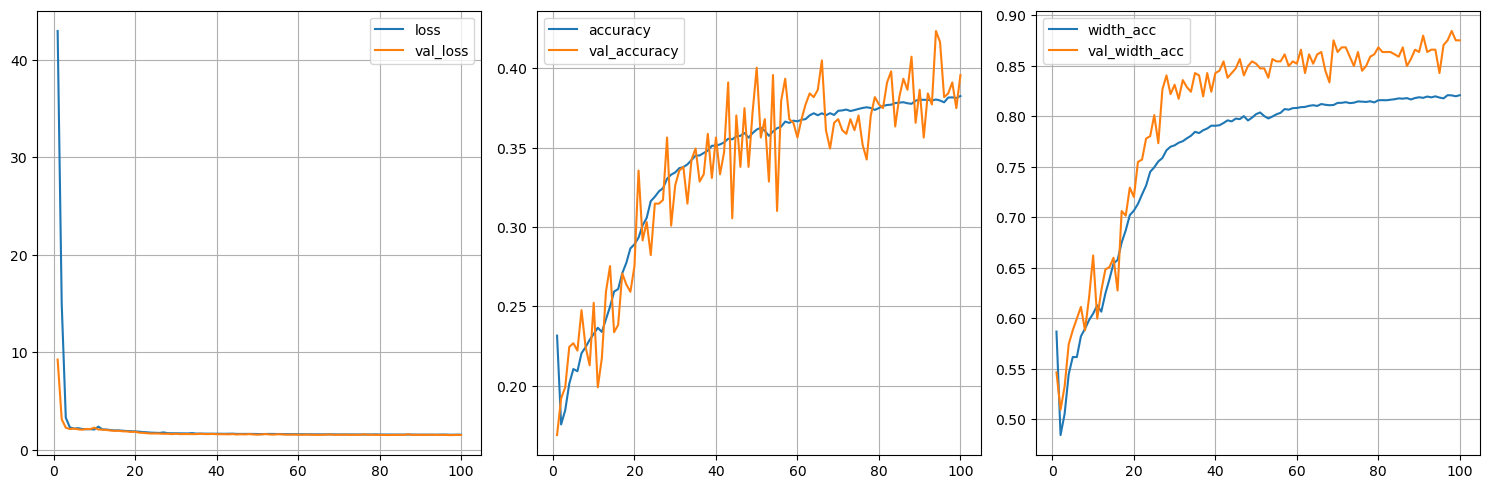

760/760 [==============================] - 3s 4ms/step - loss: 1.5419 - accuracy: 0.3826 - width_acc: 0.8207 - val_loss: 1.5110 - val_accuracy: 0.3958 - val_width_acc: 0.8750


In [96]:
batch_size, epochs = 512, 100
lr, decay = 1e-1, 1e-3
units_list = [64] * 4
data = prep_data((train["norm"], val["norm"], train["pic"], val["pic"]))
input_shape = (MAX_PLUECKER_LEN,)
model = mlp_model(input_shape=input_shape, units_list=units_list, lr=lr, decay=decay)
model, histories = train_model(model, data, batch_size=batch_size, epochs=epochs)